In [1]:
import numpy as np
import matplotlib.pyplot as plt

The canonical Burger's equation is
$$u_t + u u_x = \nu u_{xx}\,,$$
which is essentially an advective-diffusive equation of momentum. In this notebook, we replicate [Zingale's finite-volume implementation](https://zingale.github.io/comp_astro_tutorial/advection_euler/burgers/burgers-methods.html).

The flux form of the equation is
$$u_t + \left[\frac{1}{2}u^2\right]_x = \nu u_{xx}\,,$$
where $F^a(u) = \frac{1}{2}u^2$ is the advective flux. In the finite volume approach, the tendency of momentum is the difference between the area-integrated flux coming in/out through the cell interface:

$$\frac{\partial u_{i+1/2}}{\partial t} = - \frac{1}{\Delta x} (F^a_{i+1} - F^a_{i}) + \frac{1}{\Delta x} (F^v_{i+1} - F^v_{i})\,,$$
where $F^v_i = \frac{\nu}{\Delta x} (u_{i+1/2} - u_{i-1/2})$ is the viscous flux.
(We have slightly changed the notation of indicies from Zingale with a staggered C-grid in mind where the velocities are defined at cell interfaces and not center). As we are in a one-dimensional case, the area of cell interface is unity.

## We start with the non-viscous case, i.e. $\nu = 0$.

The boundary conditions are implemented either as periodic or outflow where the latter condition imposes a zero gradient at the boundaries:
$$u_{0-1} = u_0\,.$$

In [14]:
nx = 128
ng = 2
np.arange(nx+2*ng)-ng+0.5
# np.arange(nx+2*ng)-ng

array([ -1.5,  -0.5,   0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,
         7.5,   8.5,   9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,
        16.5,  17.5,  18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,
        25.5,  26.5,  27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,
        34.5,  35.5,  36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,
        43.5,  44.5,  45.5,  46.5,  47.5,  48.5,  49.5,  50.5,  51.5,
        52.5,  53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5,  60.5,
        61.5,  62.5,  63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,
        70.5,  71.5,  72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,
        79.5,  80.5,  81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,
        88.5,  89.5,  90.5,  91.5,  92.5,  93.5,  94.5,  95.5,  96.5,
        97.5,  98.5,  99.5, 100.5, 101.5, 102.5, 103.5, 104.5, 105.5,
       106.5, 107.5, 108.5, 109.5, 110.5, 111.5, 112.5, 113.5, 114.5,
       115.5, 116.5, 117.5, 118.5, 119.5, 120.5, 121.5, 122.5, 123.5,
       124.5, 125.5,

In [15]:
ng+nx-1

129

In [2]:
class FVGrid:

    def __init__(self, nx, ng, bc,
                 xmin=0.0, xmax=1.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        # python is zero-based.  Make easy intergers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords -- cell-centered, left and right edges
        self.dx = (xmax - xmin)/(nx)
        self.x  = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx
        self.xl = xmin + (np.arange(nx+2*ng)-ng)*self.dx
        self.xr = xmin + (np.arange(nx+2*ng)-ng+1.0)*self.dx

        # storage for the solution
        self.u = self.scratch_array()
        self.uinit = self.scratch_array()

        self.bc = bc
        
    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def fill_BCs(self, atmp):
        """ fill all ghostcells """
 
        if self.bc == "periodic":

            # left boundary
            atmp[0:self.ilo] = atmp[self.ihi-self.ng+1:self.ihi+1]

            # right boundary
            atmp[self.ihi+1:] = atmp[self.ilo:self.ilo+self.ng]

        elif self.bc == "outflow":

            # left boundary
            atmp[0:self.ilo] = atmp[self.ilo]

            # right boundary
            atmp[self.ihi+1:] = atmp[self.ihi]

        else:
            
            sys.exit("invalid BC")

    def norm(self, e):
        """ return the norm of quantity e which lives on the grid """
        if not len(e) == (2*self.ng + self.nx):
            return None

        return np.sqrt(self.dx*np.sum(e[self.ilo:self.ihi+1]**2))
    
    def plot(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)

        ax.plot(self.x, self.uinit, label="initial conditions")
        ax.plot(self.x, self.u)
        ax.legend()
        return fig

If there is compression $u_l > u_r$, then we have a shock, and we need to compute the shock speed and then upwind based on that.  For the Burgers' equation, the shock speed is obtained via the Rankine-Hugoniot jump conditions as:

$$S = \frac{F(u_r) - F(u_l)}{u_r - u_l} = \frac{ \frac{1}{2}u_r^2 - \frac{1}{2}u_l^2}{u_r - u_l} = \frac{1}{2} (u_l + u_r)\,.$$

We implement this using the [flux limiter](https://en.wikipedia.org/wiki/Flux_limiter).
For an interface in our domain:

$$S = \frac{1}{2} \left(u_{i+1/2,l} + u_{i+1/2,r}\right)\,.$$

Then our Riemann problem is 

$$u_{i+1/2} = \mathcal{R}\left(u_{i+1/2,l}, u_{i+1/2,r}\right) = \left \{ \begin{array}{cc}
         u_s & \mbox{if}~ u_{i+1/2,l} > u_{i+1/2,r} \\
         u_r & \mbox{otherwise} \end{array} \right .
$$

where $u_s$ is the shock case:

$$u_s = \left \{ \begin{array}{cc}
     u_{i+1/2,l} & \mbox{if}~ S > 0\ \ (\text{positive propagation}) \\
     u_{i+1/2,r} & \mbox{if}~ S < 0\ \ (\text{negative propagation}) \end{array} \right .
$$

and $u_r$ is the rarefaction case:

$$u_r = \left \{ \begin{array}{cc}
     u_{i+1/2,l} & \mbox{if}~ u_{i+1/2,l} > 0 \\
     u_{i+1/2,r} & \mbox{if}~ u_{i+1/2,r} < 0 \\
     0           & \mbox{otherwise} \end{array} \right .\,.
$$

Once we have the interface state, $u_{i+1/2}$, we can compute the flux:

$$F^a_{i+1} = \frac{1}{2} \left(\frac{u_{i+1/2} + u_{i+3/2}}{2}\right)^2$$

and then the divergence of the fluxes:

$$-\frac{1}{\Delta x} \left(F^a_{i+1} - F^a_{i}\right) = -\frac{1}{8\Delta x} \left[ (u_{i+1/2} + u_{i+3/2})^2 - (u_{i+1/2} + u_{i-1/2})^2 \right]$$

In [3]:
def flux_update(gr, u):
    """compute -div{F} for linear advection"""

    # Slope -- we'll do the minmod limiter
    
    # dl = u_{i+1/2} - u_{i-1/2}
    dl = gr.scratch_array()
    dl[gr.ilo-1:gr.ihi+2] = u[gr.ilo-1:gr.ihi+2] - u[gr.ilo-2:gr.ihi+1]

    # dr = u_{i+3/2} - u_{i+1/2}
    dr = gr.scratch_array()
    dr[gr.ilo-1:gr.ihi+2] = u[gr.ilo:gr.ihi+3] - u[gr.ilo-1:gr.ihi+2]
    
    d1 = np.where(np.fabs(dl) < np.fabs(dr), dl, dr)
    du = np.where(dl*dr > 0.0, d1, 0.0)
    
    # Compute the left and right interface states
    # Note that there are 1 more interfaces than zones

    ul = gr.scratch_array()
    ur = gr.scratch_array()
    
    # u_{i+1/2,R} = u_{i+3/2} - 1/2 du_{i+3/2}
    ur[gr.ilo:gr.ihi+2] = u[gr.ilo:gr.ihi+2] - 0.5 * du[gr.ilo:gr.ihi+2]

    # u_{i+1/2,L} = u_{i-1/2} + 1/2 du_{i-1/2}
    ul[gr.ilo:gr.ihi+2] = u[gr.ilo-1:gr.ihi+1] + 0.5 * du[gr.ilo-1:gr.ihi+1]
    
    # Now do the Riemann problem
    
    S = 0.5 * (ul + ur)
    ushock = np.where(S > 0.0, ul, ur)
    ushock = np.where(S == 0.0, 0.0, ushock)
    
    # Rarefaction solution
    urare = np.where(ur <= 0.0, ur, 0.0)
    urare = np.where(ul >= 0.0, ul, urare)
    
    # If we are compressive, then we are a shock
    us = np.where(ul > ur, ushock, urare)
    
    flux_diff = gr.scratch_array()
    flux_diff[gr.ilo:gr.ihi+1] = ((0.5 * (us[gr.ilo:gr.ihi+1]+us[gr.ilo-1:gr.ihi]))**2
                                  - (0.5 * (us[gr.ilo:gr.ihi+1]+us[gr.ilo+1:gr.ihi+2]))**2
                                 ) / gr.dx * .5

    return flux_diff

In [4]:
def burgers_mol(nx, ng, C, tmax, init_cond=None, bc="outflow"):

    # create a grid
    g = FVGrid(nx, ng, bc)

    # setup initial conditions
    init_cond(g)

    g.uinit[:] = g.u[:]
    
    t = 0.0
    while t < tmax:

        # compute the timestep (based on the CFL condition)
        dt = C * g.dx / np.abs(g.u).max()

        if t + dt > tmax:
            dt = tmax - t

        # second-order RK integration
        g.fill_BCs(g.u)
        k1 = flux_update(g, g.u)

        utmp = g.scratch_array()
        utmp[:] = g.u[:] + 0.5 * dt * k1[:]

        g.fill_BCs(utmp)
        k2 = flux_update(g, utmp)

        g.u[:] += dt * k2[:]

        t += dt

    return g

In [5]:
def sine(g):
    g.u[:] = 1.0

    index = np.logical_and(g.x >= 0.333,
                           g.x <= 0.666)
    g.u[index] += 0.5*np.sin(2.0*np.pi*(g.x[index]-0.333)/0.333)

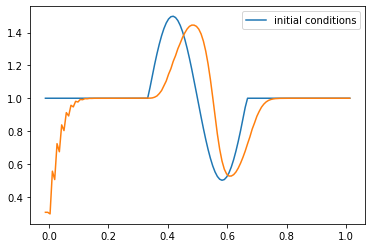

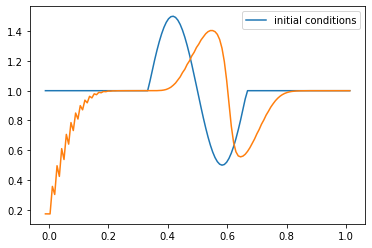

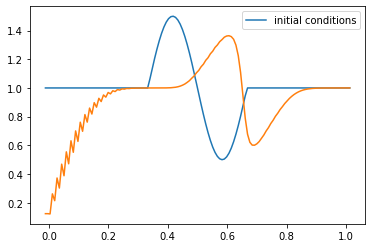

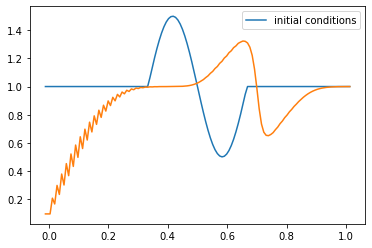

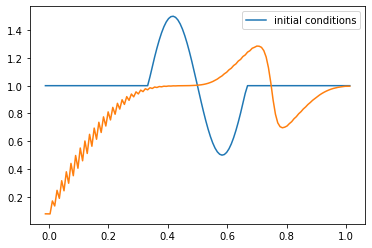

In [6]:
nx   = 128
C    = 0.5
tmax = 0.25
ng   = 2

for tmax in [0.05, 0.10, 0.15, 0.20, 0.25]:
    g = burgers_mol(nx, ng, C, tmax, init_cond=sine)
    fig = g.plot()